**CURSO**: Análisis Geoespacial, Departamento de Geociencias y Medio Ambiente, Universidad Nacional de Colombia - sede Medellín <br/>
**Profesor**: Edier Aristizábal (evaristizabalg@unal.edu.co) <br />
**Credits**: The content of this notebook is taken from several sources, such as [Muntasir Wahed](https://medium.com/analytics-vidhya/the-beginners-guide-to-choropleth-maps-in-python-ff1da28a8943), but specially from the courses and book open and freely published by [Dani Arribas-Bel](http://darribas.org/) -  University of Liverpool & - Sergio Rey - [Center for Geospatial Sciences, University of California, Riverside](http://spatial.ucr.edu/peopleRey.html). Every effort has been made to trace copyright holders of the materials used in this book. The author apologies for any unintentional omissions and would be pleased to add an acknowledgment in future editions. 

# Análisis Exploratorio de Datos Espaciales (ESDA)

En esta sesión aprenderemos a explorar la autocorrelación espacial en un conjunto de datos dado, analizando la información sobre su presencia, naturaleza e intensidad. Para ello, utilizaremos un conjunto de herramientas conocidas como Análisis Exploratorio de Datos Espaciales (AEDE), diseñadas específicamente para este propósito.

La gama de métodos AEDE es muy amplia, desde enfoques menos sofisticados como coropletas y consultas generales de tablas, hasta metodologías más avanzadas y robustas que incluyen inferencia estadística y un reconocimiento explícito de la dimensión geográfica de los datos. El objetivo de esta sesión es introducirnos en este último grupo.

Las técnicas AEDE se suelen dividir en dos grupos principales: herramientas para analizar la autocorrelación espacial global y local. La primera considera la tendencia general que sigue la ubicación de los valores, y permite hacer afirmaciones sobre el grado de agrupamiento en el conjunto de datos. ¿Los valores siguen generalmente un patrón particular en su distribución geográfica? ¿Los valores similares están más cerca de otros valores similares de lo que esperaríamos por puro azar? Estas son algunas de las preguntas que permiten responder las herramientas de autocorrelación espacial global. Practicaremos con la autocorrelación espacial global utilizando el estadístico I de Moran.

Por el contrario, las herramientas de autocorrelación espacial local se centran en la inestabilidad espacial: la desviación de algunas partes del mapa de la tendencia general. La idea aquí es que, aunque exista una tendencia determinada para los datos en cuanto a la naturaleza y la fuerza de la asociación espacial, algunas áreas particulares pueden divergir considerablemente del patrón general. Independientemente del grado general de concentración de los valores, podemos observar zonas de valores inusualmente altos (bajos) cercanos a otros valores altos (bajos), a lo que llamaremos puntos calientes (fríos). Además, también es posible observar algunos valores altos (bajos) rodeados de valores bajos (altos), lo que denominaremos valores atípicos espaciales.

In [ ]:
!pip install pysal

In [ ]:
!pip install contextily

In [3]:
%matplotlib inline

import seaborn as sns
import pandas as pd
from pysal.lib import weights
#from pysal.explore import esda
from pysal.viz import splot
from splot.esda import plot_moran
import geopandas as gpd
import numpy as np
import contextily as ctx
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter("ignore")

## Data
Para esta sesión, utilizaremos los resultados del referéndum de 2016 sobre la salida del Reino Unido de la Unión Europea (UE), a nivel de autoridad local. Nos centraremos en la distribución espacial del voto a favor de la salida, que finalmente ganó.

Desde un punto de vista técnico, trabajarán con polígonos a los que se les ha asociado un valor (el porcentaje del electorado que votó por salir de la UE).

Para su comodidad, todos los datos necesarios se han reunido en un único archivo GeoPackage que contiene información geográfica sobre cada autoridad local de Inglaterra, Gales y Escocia, así como los atributos de los votos. El GeoPackage presenta varias ventajas sobre el shapefile más tradicional (la principal, la necesidad de un solo archivo en lugar de varios).

El archivo está disponible para descargar desde el siguiente enlace:

In [1]:
br_path = 'http://darribas.org/gds19/content/labs/data/brexit.gpkg'

In [4]:
br = gpd.read_file(br_path)
br.head(2)

,OBJECTID,LAD14CD,LAD14NM,LAD14NMW,id,Region_Cod,Region,Area,Electorate,ExpectedBa,...,Leave,Rejected_B,No_officia,Voting_for,Writing_or,Unmarked_o,Pct_Remain,Pct_Leave,Pct_Reject,geometry
0,1,E06000001,Hartlepool,NaN,70,E12000001,North East,Hartlepool,70341,46137,...,32071,34,0,12,6,16,30.43,69.57,0.07,"MULTIPOLYGON (((-141202.225 7308889.307, -1411..."
1,2,E06000002,Middlesbrough,NaN,71,E12000001,North East,Middlesbrough,94612,61395,...,40177,35,0,16,1,18,34.52,65.48,0.06,"MULTIPOLYGON (((-139272.615 7282988.170, -1390..."


### Cargando y explorando los datos

In [5]:
br = gpd.read_file(br_path).set_index('LAD14CD', drop=False)
br.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 380 entries, E06000001 to W06000024
Data columns (total 25 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    380 non-null    int64   
 1   LAD14CD     380 non-null    object  
 2   LAD14NM     380 non-null    object  
 3   LAD14NMW    22 non-null     object  
 4   id          380 non-null    int64   
 5   Region_Cod  380 non-null    object  
 6   Region      380 non-null    object  
 7   Area        380 non-null    object  
 8   Electorate  380 non-null    int64   
 9   ExpectedBa  380 non-null    int64   
 10  VerifiedBa  380 non-null    int64   
 11  Pct_Turnou  380 non-null    float64 
 12  Votes_Cast  380 non-null    int64   
 13  Valid_Vote  380 non-null    int64   
 14  Remain      380 non-null    int64   
 15  Leave       380 non-null    int64   
 16  Rejected_B  380 non-null    int64   
 17  No_officia  380 non-null    int64   
 18  Voting_for  380 non-null    int64

In [6]:
br.head(2)

,OBJECTID,LAD14CD,LAD14NM,LAD14NMW,id,Region_Cod,Region,Area,Electorate,ExpectedBa,...,Leave,Rejected_B,No_officia,Voting_for,Writing_or,Unmarked_o,Pct_Remain,Pct_Leave,Pct_Reject,geometry
LAD14CD,,,,,,,,,,,,,,,,,,,,,
E06000001,1,E06000001,Hartlepool,NaN,70,E12000001,North East,Hartlepool,70341,46137,...,32071,34,0,12,6,16,30.43,69.57,0.07,"MULTIPOLYGON (((-141202.225 7308889.307, -1411..."
E06000002,2,E06000002,Middlesbrough,NaN,71,E12000001,North East,Middlesbrough,94612,61395,...,40177,35,0,16,1,18,34.52,65.48,0.06,"MULTIPOLYGON (((-139272.615 7282988.170, -1390..."


Aunque hay varias variables que podrían considerarse, nos centraremos en Pct_Leave, que mide la proporción de votos a favor de la opción "Leave". Para mayor comodidad, fusionemos los resultados de votación con los datos espaciales.

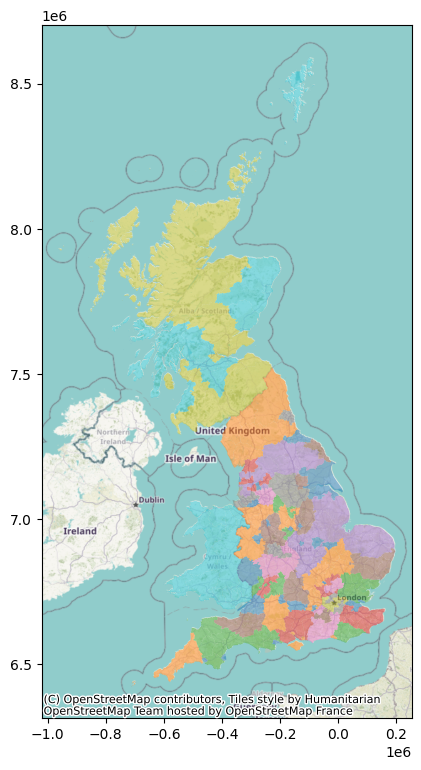

In [8]:
ax = br.plot(column="LAD14CD", figsize=(9, 9), alpha=0.5);
# Add background map, expressing target CRS so the basemap can be
# reprojected (warped)
ctx.add_basemap(ax, crs=br.crs)

Antes de pasar a la parte analítica, también podemos crear un mapa coroplético:

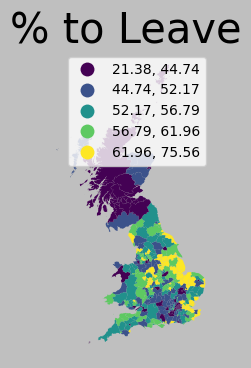

In [10]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(4, 4))
# Plot % to leave
br.plot(column='Pct_Leave', scheme='Quantiles', legend=True, ax=ax)
# Remove axis frame
ax.set_axis_off()
# Change background color of the figure
f.set_facecolor('0.75')
# Title
f.suptitle('% to Leave', size=30)
# Draw
plt.show()

## Autocorrelación espacial

La autocorrelación espacial tiene que ver con el grado en que la similitud en los valores entre observaciones en un conjunto de datos está relacionada con la similitud en las ubicaciones de dichas observaciones. No es completamente diferente de la correlación tradicional entre dos variables, que nos informa sobre cómo cambian los valores en una variable en función de los de la otra, y es análoga a su contraparte de series temporales, que relaciona el valor de una variable en un momento dado con los de períodos anteriores. La autocorrelación espacial relaciona el valor de la variable de interés en una ubicación dada con los valores de la misma variable en ubicaciones circundantes.

Una idea clave en este contexto es la de aleatoriedad espacial: una situación en la que la ubicación de una observación no proporciona ninguna información sobre su valor. En otras palabras, una variable es espacialmente aleatoria si se distribuye sin seguir un patrón discernible sobre el espacio. Por lo tanto, la autocorrelación espacial puede definirse formalmente como la "ausencia de aleatoriedad espacial", lo que da lugar a dos clases principales de autocorrelación, similares al caso tradicional: autocorrelación espacial *positiva*, cuando los valores similares tienden a agruparse en ubicaciones similares; y autocorrelación espacial *negativa*, en casos donde los valores similares tienden a dispersarse y estar más separados entre sí.


La herramienta fundamental para evaluar la relación espacial entre observaciones corresponde a la matriz espacial de pesos. La matriz de pesos tiene dimensiones de $N$ by $N$, donde $N$ es el número total de observaciones:

$$
W = \left(\begin{array}{cccc}
0 & w_{12} & \dots & w_{1N} \\
w_{21} & \ddots & w_{ij} & \vdots \\
\vdots & w_{ji} & 0 & \vdots \\
w_{N1} & \dots & \dots & 0 
\end{array} \right)
$$

Donde cada celda $w_{ij}$ corresponde a un valor que representa el grado espacial de contacto o interacción entre los valores $i$ y $j$. Por convención, la diagonal ($w_{ij}$) son ceros. El valor $W$ de $i$ y $j$ son vecinas si $w_{ij}>0$.


Una matriz de pesos espaciales es la forma en que el espacio geográfico se codifica formalmente en una forma numérica para que sea fácil de entender para una computadora (o un método estadístico). Ya hemos visto muchas de las formas conceptuales en las que podemos definir una matriz de pesos espaciales, como la contigüidad, basada en la distancia o en bloques.
.

### Matriz de pesos basada en contiguidad
Para este ejemplo, mostraremos cómo construir una matriz de contigüidad de reina, que considera dos observaciones como vecinas si comparten al menos un punto de su límite. En otras palabras, para que un par de autoridades locales en el conjunto de datos sean consideradas vecinas bajo este $W$, necesitarán compartir frontera o, en otras palabras, "tocarse" en cierto grado. Se llama **Queen**.


In [11]:
w_queen = weights.Queen.from_dataframe(br, idVariable="LAD14CD")
w_queen

Con la matriz de pesos de Queen podemos saber cuales son los poligonos vecinos para cualquier observación:

In [18]:
w_queen['E06000003']

{'E06000001': 1.0,
 'E06000002': 1.0,
 'E06000004': 1.0,
 'E07000164': 1.0,
 'E07000168': 1.0}

In [19]:
w_queen.neighbors['E06000003']

['E06000004', 'E07000168', 'E07000164', 'E06000002', 'E06000001']

In [20]:
w_queen.weights['E06000007']

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

Ademas permite conocer la relación de vencindad entre dos observaciones específicas:

In [24]:
w_queen['E06000003']['E07000164']

1.0

Al igual que el número de vecinos para cada observación:

In [25]:
w_queen.cardinalities['E06000003']

5

Para conocer el número de vecinos para cada observación se puede obtener la siguiente tabla:

In [ ]:
queen_card = pd.Series(w_queen.cardinalities)
queen_card.head(10)

E06000001    3
E06000002    3
E06000003    5
E06000004    6
E06000005    4
E06000006    5
E06000007    7
E06000008    7
E06000009    2
E06000010    1
dtype: int64

Para graficar una observación y sus vecinos utilizamos el siguiente script:

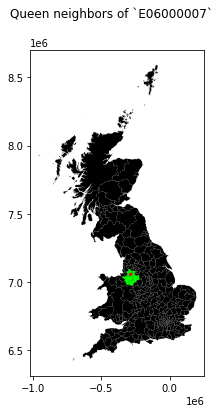

In [ ]:
# Setup figure
f, ax = plt.subplots(1, figsize=(6, 6))
# Plot base layer of polygons
br.plot(ax=ax, facecolor='k', linewidth=0.1)
# Select focal polygon
# NOTE we pass both the area code and the column name
#      (`geometry`) within brackets!!!
focus = br.loc[['E06000007'], ['geometry']]
# Plot focal polygon
focus.plot(facecolor='red', alpha=1, linewidth=0, ax=ax)
# Plot neighbors
neis = br.loc[w_queen['E06000007'], :]
neis.plot(ax=ax, facecolor='lime', linewidth=0)
f.suptitle("Queen neighbors of `E06000007`")
plt.show()

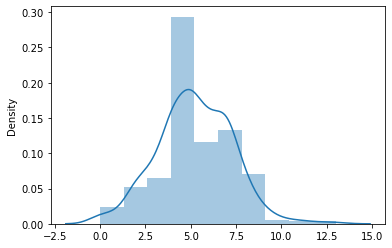

In [ ]:
sns.distplot(queen_card, bins=10);

El histograma anterior señala que el número de vecinos promedios de cada observación está alrededor de 5, y que el máximo número de vecinos de una observación corresponde a 13 y que existen observaciones sin vecinos, es decir sola y separada del resto. Lo cual se puede verificar a continuación:

In [ ]:
w_queen.max_neighbors

13

In [ ]:
w_queen.islands

['E06000046', 'E06000053', 'S12000013', 'S12000023', 'S12000027', 'W06000001']

La celda donde calculamos $W$ devolvió una advertencia sobre "islas". Recuerda que estas son islas no necesariamente en el sentido geográfico (aunque algunas lo serán), sino en el sentido matemático del término: autoridades locales que no comparten frontera con ninguna otra y, por lo tanto, no tienen vecinos. Podemos inspeccionar y mapearlas para tener una mejor idea de con qué estamos tratando.


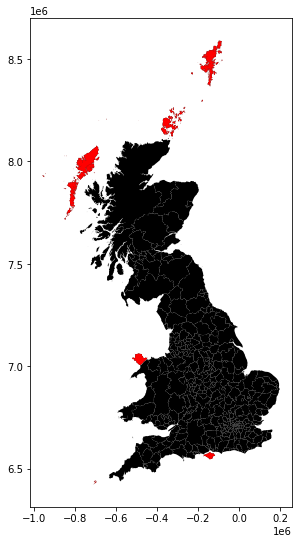

In [ ]:
ax = br.plot(color='k', figsize=(9, 9))
br.loc[w_queen.islands, :].plot(color='red', ax=ax);

En este caso, todas las islas son realmente "islas" en el sentido geográfico. Estos casos pueden crear problemas en el análisis y distorsionar los resultados. Hay varias soluciones a esta situación, como conectar las islas a otras observaciones a través de un criterio diferente (por ejemplo, el vecino más cercano), y luego combinar ambas matrices de pesos espaciales. Por conveniencia, las eliminaremos del conjunto de datos porque son una muestra pequeña y su eliminación probablemente no tendrá un gran impacto en los cálculos.eE este caso usaremos el comando `drop`, que es muy útil en estos casos:


In [ ]:
br = br.drop(w_queen.islands)

Una vez que tengamos el conjunto de autoridades locales que no son islas, necesitamos volver a calcular la matriz de pesos:


In [ ]:
# Create the spatial weights matrix
w = weights.Queen.from_dataframe(br, idVariable='LAD14CD')

Y, finalmente, vamos a estandarizar por filas para asegurarnos de que cada fila de la matriz sume uno:


In [ ]:
# Row standardize the matrix
w.transform = 'R'

Ahora, debido a que los hemos estandarizado por filas, el peso dado a cada uno de los cuatro vecinos es 0.2, lo que, en total, suma uno.


In [ ]:
w['E08000012']

{'E06000006': 0.2,
 'E08000011': 0.2,
 'E08000015': 0.2,
 'E08000014': 0.2,
 'E06000050': 0.2}

### Matriz de pesos basada en distancias

Las matrices de pesos basadas en la distancia asignan los pesos de acuerdo con dicha distancia. Es importante para este tipo de análisis contar con los datos proyectados a un sistema de coordenadas planas y no geográfico, de tal forma que permita medir distancias. Para este caso se debe reproyectar:

In [ ]:
imd=br.to_crs(epsg=27700)

Para el caso del método de vecino mas cercano (KNN) se debe ingresar como argumento el número de vecinos a considerar. 

In [ ]:
knn5 = weights.KNN.from_dataframe(imd, k=5)
knn5['E06000007']

{'E06000006': 1.0,
 'E08000013': 1.0,
 'E08000009': 1.0,
 'E08000010': 1.0,
 'E08000006': 1.0}

In [ ]:
knn5.weights['E06000007']

[1.0, 1.0, 1.0, 1.0, 1.0]

In [ ]:
knn5.neighbors['E06000007']

['E06000006', 'E08000013', 'E08000009', 'E08000010', 'E08000006']

In [ ]:
knn5_card = pd.Series(knn5.cardinalities)
knn5_card.head(10)

E06000001    5
E06000002    5
E06000003    5
E06000004    5
E06000005    5
E06000006    5
E06000007    5
E06000008    5
E06000009    5
E06000010    5
dtype: int64

Otra forma de hacerlo es identificar manualmente el centroide de cada poligono.

In [ ]:
cents = imd.centroid
pts = np.array([(pt.x, pt.y) for pt in cents]) # Extract coordinates into an array
knn5_from_pts = weights.KNN.from_array(pts, k=5) # Compute KNN weights
knn5_from_pts

Para conocer el número de vecinos en una distancia dada se utiliza el método de Bandas, donde a cada observación dentro del rango establecido se le asigna un peso igual al inverso de la distancia:

$$
w_{ij} = \dfrac{1}{d_{ij}}
$$

In [ ]:
w_dist50kmB = weights.DistanceBand.from_dataframe(imd, 50000)

In [ ]:
w_dist50kmB['E06000007']

{'E06000006': 1.0,
 'E06000008': 1.0,
 'E06000049': 1.0,
 'E06000050': 1.0,
 'E07000037': 1.0,
 'E07000117': 1.0,
 'E07000118': 1.0,
 'E07000119': 1.0,
 'E07000120': 1.0,
 'E07000123': 1.0,
 'E07000125': 1.0,
 'E07000126': 1.0,
 'E07000127': 1.0,
 'E07000195': 1.0,
 'E08000001': 1.0,
 'E08000002': 1.0,
 'E08000003': 1.0,
 'E08000004': 1.0,
 'E08000005': 1.0,
 'E08000006': 1.0,
 'E08000007': 1.0,
 'E08000008': 1.0,
 'E08000009': 1.0,
 'E08000010': 1.0,
 'E08000011': 1.0,
 'E08000012': 1.0,
 'E08000013': 1.0,
 'E08000014': 1.0,
 'E08000015': 1.0,
 'W06000005': 1.0}

In [ ]:
w_dist50kmC = weights.DistanceBand.from_dataframe(imd, 50000, binary=False)

In [ ]:
w_dist50kmC['E06000007']

{'E06000006': 8.329860278843111e-05,
 'E06000008': 3.0028321643294143e-05,
 'E06000049': 3.548816060468974e-05,
 'E06000050': 4.015427757479157e-05,
 'E07000037': 2.175664883027904e-05,
 'E07000117': 2.0850740643018106e-05,
 'E07000118': 3.3609688075961276e-05,
 'E07000119': 2.0405911604693417e-05,
 'E07000120': 2.4006210536332285e-05,
 'E07000123': 2.1369140954130304e-05,
 'E07000125': 2.6146250477470806e-05,
 'E07000126': 2.6381508522990962e-05,
 'E07000127': 3.1666293230041456e-05,
 'E07000195': 2.083196645230684e-05,
 'E08000001': 4.759810994921764e-05,
 'E08000002': 3.727398720196612e-05,
 'E08000003': 4.391855591128467e-05,
 'E08000004': 2.626773678904094e-05,
 'E08000005': 2.7617774905611036e-05,
 'E08000006': 6.120206641739688e-05,
 'E08000007': 3.452418619344428e-05,
 'E08000008': 2.906865957567783e-05,
 'E08000009': 7.129303100480003e-05,
 'E08000010': 7.117271649207412e-05,
 'E08000011': 5.490987586575155e-05,
 'E08000012': 4.25500161957151e-05,
 'E08000013': 7.9412232674840

La forma grafica del anterior análisis se puede ejecutar de la siguiente forma:

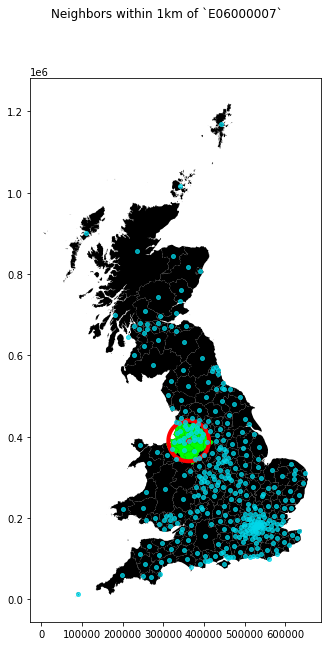

In [ ]:
# Setup figure
f, ax = plt.subplots(1, figsize=(10, 10))
# Plot base layer of polygons
imd.plot(ax=ax, facecolor='k', linewidth=0.1)
# Select focal polygon
# NOTE we pass both the area code and the column name
#      (`geometry`) within brackets!!!
focus = imd.loc[['E06000007'], ['geometry']]
# Plot focal polygon
focus.plot(facecolor='red', alpha=1, linewidth=0, ax=ax)
# Plot neighbors
neis = imd.loc[w_dist50kmC['E06000007'], :]
neis.plot(ax=ax, facecolor='lime', linewidth=0)
# Plot 1km buffer
buf = focus.centroid.buffer(50000)
buf.plot(edgecolor='red', facecolor='none', ax=ax, linewidth=4)
# Plot centroids of neighbor
pts = np.array([(pt.x, pt.y) for pt in imd.centroid])
ax.plot(pts[:, 0], pts[:, 1], color='#00d8ea', 
        linewidth=0, alpha=0.75, marker='o', markersize=4)
# Title
f.suptitle("Neighbors within 1km of `E06000007`")
# Style, zoom and display on screen
#ax.set_ylim(388000, 393500)
#ax.set_xlim(336000, 339500)
plt.show()

### Spatial lag

El *spatial lag* de una variable es el prodcuto de la matriz de pesos con la variable misma.

$$
Y_{sl} = W Y
$$
 
Donde 𝑌  es un vector Nx1 con los valores de la variable.

$$
y_{sl-i} = \displaystyle \sum_j w_{ij} y_j
$$

Una vez que tengamos los datos y la matriz de pesos espaciales listos, podemos comenzar calculando el retraso espacial del porcentaje de votos que se emitieron para salir de la UE. Recuerda que el retraso espacial es el producto de la matriz de pesos espaciales y una variable dada, y que si $W$ está estandarizado por filas, el resultado equivale al valor promedio de la variable en el vecindario de cada observación.

Podemos calcular el *spatial lag* para la variable `Pct_Leave` y almacenarlo directamente en la tabla principal con la siguiente línea de código:


In [ ]:
br['w_Pct_Leave'] = weights.lag_spatial(w, br['Pct_Leave'])

Demos un vistazo rápido a la variable resultante, en comparación con la original:


In [ ]:
br[['LAD14NM', 'Pct_Leave', 'w_Pct_Leave']].head()

,LAD14NM,Pct_Leave,w_Pct_Leave
LAD14CD,,,
E06000001,Hartlepool,69.57,61.823333
E06000002,Middlesbrough,65.48,60.526667
E06000003,Redcar and Cleveland,66.19,62.486000
E06000004,Stockton-on-Tees,61.73,61.438333
E06000005,Darlington,56.18,57.430000


La forma de interpretar el retraso espacial (`w_Pct_Leave`) para, por ejemplo, la primera observación, es la siguiente: Hartlepool, donde el 69,6% del electorado votó para salir, está rodeado por autoridades locales vecinas donde, en promedio, casi el 62% del electorado también votó para salir de la UE. Para fines de ilustración, de hecho podemos verificar que esto es correcto consultando la matriz de pesos espaciales para averiguar los vecinos de Hartepool:


In [ ]:
w.neighbors['E06000001']

['E06000047', 'E06000003', 'E06000004']

Estos son los valores de las expectativas teóricas para cada tipo de unión:


In [ ]:
neis = br.loc[w.neighbors['E06000001'], 'Pct_Leave']
neis

LAD14CD
E06000047    57.55
E06000003    66.19
E06000004    61.73
Name: Pct_Leave, dtype: float64

Y el valor promedio, que vimos en el retraso espacial como 61.8, se puede calcular de la siguiente manera:


In [ ]:
neis.mean()

61.82333333333333

Para comparar fácilmente diferentes gráficos de dispersión y detectar observaciones atípicas, es práctica común estandarizar los valores de la variable antes de calcular su retraso espacial y representarlo. Esto se puede lograr restando el valor promedio y dividiendo el resultado por la desviación estándar:

$
z_i = \frac{y - \bar{y}}{\sigma_y}
$

Estandarizar significa restar el valor promedio y dividir por la desviación estándar cada observación de la columna. Esto se puede hacer fácilmente con un poco de álgebra básica en Python:

In [ ]:
br['Pct_Leave_std'] = (br['Pct_Leave'] - br['Pct_Leave'].mean()) / br['Pct_Leave'].std()

Finalmente, para poder explorar los patrones espaciales de los valores estandarizados, a veces también llamados valores $z$, necesitamos crear su retraso espacial:


In [ ]:
br['w_Pct_Leave_std'] = weights.lag_spatial(w, br['Pct_Leave_std'])

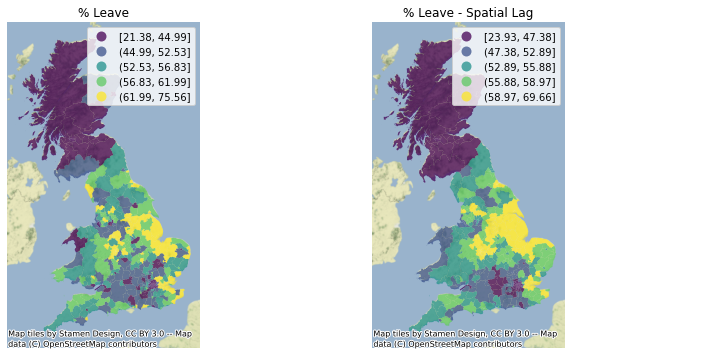

In [ ]:
f, axs = plt.subplots(1, 2, figsize=(12, 6))
ax1, ax2 = axs
br.plot(column='Pct_Leave', cmap='viridis', scheme='quantiles',k=5, edgecolor='white', linewidth=0., alpha=0.75, legend=True, ax=ax1)
ax1.set_axis_off()
ax1.set_title("% Leave")
ctx.add_basemap(ax1,crs=br.crs,source=ctx.providers.Stamen.TerrainBackground)
br.plot(column='w_Pct_Leave', cmap='viridis', scheme='quantiles',k=5, edgecolor='white', linewidth=0., alpha=0.75, legend=True, ax=ax2)
ax2.set_axis_off()
ax2.set_title("% Leave - Spatial Lag")
ctx.add_basemap(ax2,crs=br.crs,source=ctx.providers.Stamen.TerrainBackground,)
plt.show()

Las marcadas diferencias a la izquierda entre vecinos inmediatos (como en el caso de Liverpool, en el noroeste de Inglaterra) se atenúan en el mapa de la derecha.


### Autocorrelación espacial global

El mapa anterior es una buena manera de comenzar a explorar los principales patrones espaciales en los datos. A primera vista, parece mostrar una cantidad considerable de autocorrelación espacial positiva: las autoridades locales con altos porcentajes de votos para salir de la UE tienden a estar cerca unas de otras (ver, por ejemplo, la región oriental), al igual que aquellas donde una proporción mucho menor de su población votó para salir (con Escocia siendo un buen ejemplo en el norte). Sin embargo, los humanos son muy buenos detectores de patrones. A lo largo de nuestra historia desde que empezamos como especie, la vida ha recompensado las habilidades de reconocimiento de patrones y ha castigado a los individuos que carecen de ellas. Piensa en la ventaja que tenían nuestros ancestros si podían detectar formas o movimientos particulares mientras cazaban, o en los problemas en los que podían meterse si no eran capaces de reconocer a ciertos otros en la oscuridad de la noche en la selva. Esta extraordinaria capacidad para detectar tendencias, patrones y asociaciones también tiende a crear muchos falsos positivos: casos en los que pensamos que hay un patrón pero, de hecho, lo que estamos viendo es en gran medida aleatorio. Esto se acentúa particularmente en el caso de los mapas donde, la forma de las geometrías también puede distorsionar significativamente nuestra percepción. Al observar el mapa anterior, por ejemplo, podemos hacer una suposición educada sobre la presencia de autocorrelación espacial; pero en realidad determinar si lo que estamos viendo podría haber ocurrido por pura casualidad o no suele ser más fácil decirlo que hacerlo.

Ese es exactamente el propósito de los indicadores de autocorrelación espacial global: aprovechar el poder de la estadística para ayudarnos primero a resumir la distribución espacial de los valores presentes en un mapa, y segundo obtener una cuantificación formal de la desviación de la aleatoriedad. Las estadísticas diseñadas para medir esta tendencia caracterizan así un mapa en términos de su grado de agrupamiento y lo resumen, ya sea de manera visual o numérica. Sin embargo, antes de que podamos sumergirnos en las estadísticas, necesitamos entender un bloque de construcción fundamental: *spatial lag*. Con ese concepto estamos en posición de construir una buena comprensión de la autocorrelación espacial global. Entraremos suavemente en ella con el caso binario, cuando las observaciones solo pueden tomar dos valores (potencialmente categóricos), antes de cubrir los dos del caso continuo: el Gráfico de Moran y el Índice de Moran (Moran's I).


### Caso binario: conteos de unión

El retraso espacial juega un papel importante en la cuantificación de la autocorrelación espacial. Usándolo, podemos comenzar a relacionar el comportamiento de una variable en una ubicación dada con su patrón en el vecindario inmediato. Las medidas de autocorrelación espacial global luego usarán cada observación para construir medidas generales sobre la tendencia general en un conjunto de datos dado.

Nuestra primera incursión en estas medidas considera un caso simplificado: valores binarios. Esto ocurre cuando la variable en la que estamos interesados solo toma dos valores. En este contexto, estamos interesados en saber si una observación dada está rodeada por otras dentro de la misma categoría. Por ejemplo, volviendo a nuestro conjunto de datos, queremos evaluar en qué medida las autoridades locales que votaron para salir tienden a estar rodeadas por otras que también votaron para salir. Para proceder, primero calculemos una variable binaria (Leave) que indique 1 si la autoridad local votó para salir, y cero en caso contrario:


In [ ]:
br['Leave'] = (br['Pct_Leave'] > 50).astype(int)
br[['Pct_Leave', 'Leave']].tail()

,Pct_Leave,Leave
LAD14CD,,
W06000020,59.78,1
W06000021,49.56,0
W06000022,55.99,1
W06000023,53.74,1
W06000024,56.44,1


Lo cual podemos visualizar fácilmente:


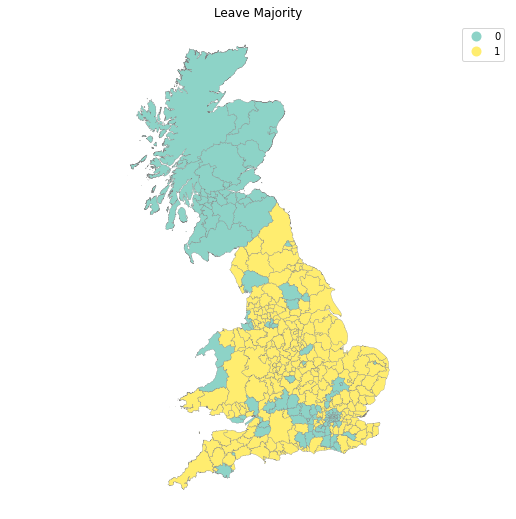

In [ ]:
f, ax = plt.subplots(1, figsize=(9, 9))
br.plot(ax=ax, column='Leave', categorical=True, legend=True, 
        edgecolor='0.5', linewidth=0.25, cmap='Set3', 
        figsize=(9, 9));
ax.set_axis_off()
ax.set_title('Leave Majority')
plt.axis('equal')
plt.show()

Visiblemente, parece que el mapa representa un claro caso de autocorrelación espacial positiva: en general, hay pocos casos visibles donde una observación dada está rodeada por otras en la categoría opuesta. Para explorar formalmente esta evaluación inicial, podemos usar lo que se llama una estadística de "conteo de unión". Imagina un tablero de ajedrez con cuadrados verdes (G, valor 0) y amarillos (Y, valor 1). La idea de la estadística es contar las ocurrencias de uniones (o pares de vecinos) verdes-verdes (GG), amarillo-amarillo (YY), o verde-amarillo/amarillo-verde (GY) en el mapa. En este contexto, tanto GG como YY reflejan autocorrelación espacial positiva, mientras que GY captura su contraparte negativa. La intuición de la estadística es proporcionar una línea de base de cuántos GG, YY y GY se esperaría bajo el caso de completa aleatoriedad espacial, y comparar esto con los recuentos observados en el conjunto de datos. Una situación donde observamos más GG/YY de lo esperado y menos GY de lo esperado sugeriría autocorrelación espacial positiva; mientras que lo opuesto, más GY que GG/YY, apuntaría hacia autocorrelación espacial negativa.

Dado que los pesos espaciales solo se usan aquí para delimitar quién es vecino o no, la estadística de conteo de unión requiere pesos binarios. Así que transformemos w de vuelta a un estado no estandarizado:


In [ ]:
w.transform

'R'

In [ ]:
w.transform = 'O'

In [ ]:
w.transform

'O'

Podemos calcular la estadística como:


In [ ]:
jc = esda.join_counts.Join_Counts(br['Leave'], w)
jc

Como es común en todo PySAL, estamos creando un objeto (jc) que contiene mucha información más allá del valor de la estadística calculada. Por ejemplo, podemos verificar cuántas ocurrencias de GG tenemos (nota el atributo es bb, que proviene de la referencia original donde las dos clases consideradas eran negras y blancas):


In [ ]:
jc.bb

580.0

¿Cuántas ocurrencias de YY tiene nuestro mapa?


In [ ]:
jc.ww

191.0

¿Y cuántas GY/YG encontramos?


In [ ]:
jc.bw

220.0

La suma de estos tres nos da el número total de comparaciones:


In [ ]:
jc.bb + jc.ww + jc.bw

991.0

In [ ]:
jc.J

991.0

La estadística se basa en comparar el número real de uniones de cada clase (bb, ww, bc) con lo que uno esperaría en un caso de aleatoriedad espacial. Esas expectativas también se pueden acceder, para el caso de GG/YY:


In [ ]:
jc.mean_bb

482.2352352352352

and for GY joins:

In [ ]:
jc.mean_bw

418.8538538538539

La inferencia estadística para obtener una idea de si estos valores probablemente provienen del azar o no se puede obtener como:


In [ ]:
jc.p_sim_bb

0.001

In [ ]:
jc.p_sim_bw

1.0

Estos resultados apuntan a una clara presencia de autocorrelación espacial positiva, ya que hay muchas más uniones de pares en la misma categoría de las que se esperaría (p_sim_bb) y significativamente menos uniones de categorías opuestas (p_sim_bw).


### Gráfico de Moran

El gráfico de Moran es una forma de visualizar un conjunto de datos espaciales para explorar la naturaleza y la fuerza de la autocorrelación espacial. Esencialmente, es un gráfico de dispersión tradicional en el que la variable de interés se muestra contra su retraso espacial. Para poder interpretar los valores como por encima o por debajo de la media, y sus cantidades en términos de desviaciones estándar, la variable de interés suele estandarizarse restando su media y dividiéndola por su desviación estándar.

Técnicamente hablando, crear un Gráfico de Moran es muy similar a crear cualquier otro gráfico de dispersión en Python, siempre que hayamos estandarizado la variable y calculado su retraso espacial de antemano:


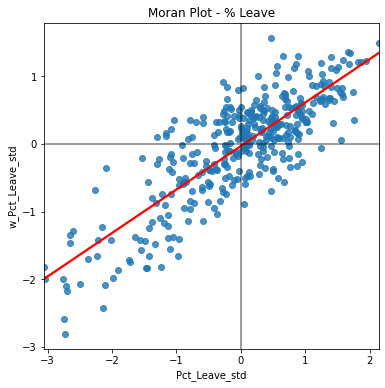

In [ ]:
br['Pct_Leave_std'] = ( br['Pct_Leave'] - br['Pct_Leave'].mean() )/ br['Pct_Leave'].std()
br['Pct_Leave_lag_std'] = ( br['w_Pct_Leave_std'] - br['w_Pct_Leave_std'].mean() )/ br['w_Pct_Leave_std'].std()

f, ax = plt.subplots(1, figsize=(6, 6))
sns.regplot(x='Pct_Leave_std', y='w_Pct_Leave_std',ci=None, data=br, line_kws={'color':'r'})
ax.axvline(0, c='k', alpha=0.5)
ax.axhline(0, c='k', alpha=0.5)
ax.set_title('Moran Plot - % Leave')
plt.show()

Otra forma de obtener esta gráfica es:

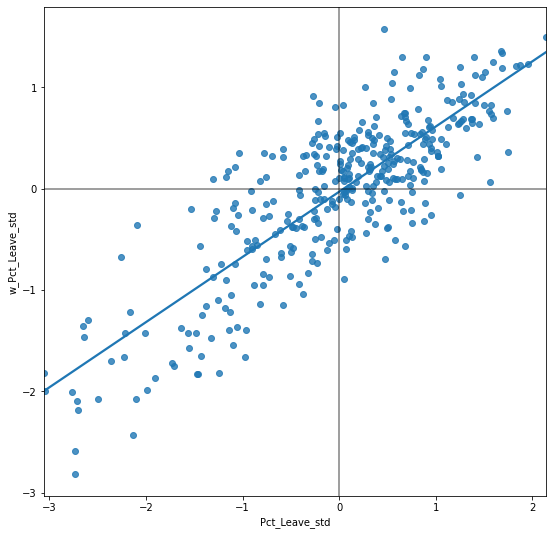

In [ ]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot values
sns.regplot(x='Pct_Leave_std', y='w_Pct_Leave_std', data=br, ci=None)
# Add vertical and horizontal lines
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
# Display
plt.show()

La figura anterior muestra la relación entre el porcentaje estandarizado que votó para salir de la UE (`Pct_Leave_std`) y su retraso espacial que, debido a que el $W$ que se utilizó está estandarizado por filas, puede interpretarse como el porcentaje promedio que votó para salir en las áreas circundantes de una Autoridad Local dada. Para guiar la interpretación del gráfico, también se incluye un ajuste lineal en la publicación. Esta línea representa el mejor ajuste lineal al gráfico de dispersión o, en otras palabras, la mejor manera de representar la relación entre las dos variables como una línea recta.

El gráfico muestra una relación positiva entre ambas variables. Esto se asocia con la presencia de autocorrelación espacial *positiva*: valores similares tienden a estar ubicados cerca uno del otro. Esto significa que la *tendencia general* es que los valores altos estén cerca de otros valores altos, y que los valores bajos estén rodeados de otros valores bajos. Sin embargo, esto no significa que esta sea la única situación en el conjunto de datos: por supuesto, puede haber casos particulares donde los valores altos estén rodeados de valores bajos, y viceversa. Pero significa que, si tuviéramos que resumir el patrón principal de los datos en términos de cuán agrupados están los valores similares, la mejor manera sería decir que están positivamente correlacionados y, por lo tanto, agrupados en el espacio.

En el contexto del ejemplo, esto se puede interpretar en el sentido de que: las autoridades locales muestran autocorrelación espacial positiva en la forma en que votaron en el referéndum de la UE. Esto significa que las autoridades locales con un alto porcentaje de votantes a favor de salir tienden a estar ubicadas cerca de otras autoridades locales donde también una parte significativa del electorado votó para salir, y viceversa.


### Índice de Moran (Moran's I)

El Gráfico de Moran es una excelente herramienta para explorar los datos y tener una buena idea de cuánto están agrupados los valores en el espacio. Sin embargo, debido a que es un dispositivo gráfico, a veces es difícil condensar sus ideas en una forma más concisa. Para estos casos, un buen enfoque es idear una medida estadística que resuma la figura. Esto es exactamente para lo que está destinado el Índice de Moran.

De la misma manera que la media resume un elemento crucial de la distribución de valores en un entorno no espacial, el Índice de Moran hace lo mismo para un conjunto de datos espaciales. Continuando con la comparación, podemos pensar en la media como un único valor numérico que resume un histograma o un gráfico de densidad de núcleo. De manera similar, el Índice de Moran captura gran parte de la esencia del Gráfico de Moran. De hecho, hay una conexión aún más cercana entre los dos: el valor del Índice de Moran corresponde con la pendiente de la ajuste lineal superpuesto en el Gráfico de Moran.

Para calcular el Índice de Moran en nuestro conjunto de datos, podemos llamar a una función específica en `PySAL` directamente:


In [ ]:
mi = esda.Moran(br['Pct_Leave'], w)

Ten en cuenta cómo no necesitamos utilizar la versión estandarizada en este contexto, ya que no la representaremos visualmente.

El método `ps.Moran` crea un objeto que contiene mucha más información que la estadística real. Si queremos recuperar el valor de la estadística, podemos hacerlo de esta manera:


In [ ]:
mi.I

0.6431732058159241

La otra información que extraeremos del Índice de Moran se relaciona con la inferencia estadística: ¿qué tan probable es que el patrón que observamos en el mapa y que captura en su valor el Índice de Moran sea generado por un proceso completamente aleatorio? Si consideráramos la misma variable pero reorganizáramos sus ubicaciones al azar, ¿obtendríamos un mapa con características similares?

Los detalles específicos del mecanismo para calcular esto están más allá del alcance de la sesión, pero es importante saber que un valor p lo suficientemente pequeño asociado con el Índice de Moran de un mapa permite rechazar la hipótesis de que el mapa es aleatorio. En otras palabras, podemos concluir que el mapa muestra más patrón espacial de lo que esperaríamos si los valores se hubieran asignado aleatoriamente a una ubicación particular.

El valor p más confiable para el Índice de Moran se puede encontrar en el atributo `p_sim`:


In [ ]:
mi.p_sim

0.001

El valor se calcula como un valor p empírico que representa la proporción de realizaciones en la simulación bajo aleatoriedad espacial que son más extremas que el valor observado. Un valor p lo suficientemente pequeño asociado con el Índice de Moran de un mapa permite rechazar la hipótesis de que el mapa es aleatorio. En otras palabras, podemos concluir que el mapa muestra más patrón espacial de lo que esperaríamos si los valores se hubieran asignado aleatoriamente a ubicaciones.

Ese es un valor muy bajo, especialmente considerando que en realidad es el valor mínimo que podríamos haber obtenido dado que la simulación detrás de él utilizó 999 permutaciones (el valor predeterminado en PySAL) y, en términos estándar, se consideraría estadísticamente significativo. Podemos elaborar un poco más sobre la intuición detrás del valor de p_sim. Si generamos un gran número de mapas con los mismos valores pero distribuidos aleatoriamente en el espacio, y calculamos la estadística del Índice de Moran para cada uno de esos mapas, solo el 0.01% de ellos mostraría un valor absoluto más grande que el que obtenemos a partir de los datos observados, y el otro 99.99% de los mapas aleatorios recibirían un valor absoluto más pequeño del Índice de Moran. Si recordamos nuevamente que el valor del Índice de Moran también se puede interpretar como la pendiente del Gráfico de Moran, lo que tenemos es que, en este caso, la disposición espacial particular de valores sobre el espacio que observamos para el porcentaje de votos a Favor de salir es más concentrada que si mezcláramos aleatoriamente las proporciones de votos en el mapa, de ahí la significación estadística. Como primer paso, el análisis de autocorrelación global puede enseñarnos que las observaciones parecen estar positivamente autocorrelacionadas en el espacio. De hecho, el patrón espacial general en la votación del Referéndum de la UE fue muy marcado: las áreas cercanas tendían a votar de manera similar.

Gracias al módulo de visualización splot en PySAL, podemos obtener una representación rápida de la estadística que combina el Gráfico de Moran (derecha) con un gráfico de la prueba empírica que llevamos a cabo para obtener p_sim (izquierda):


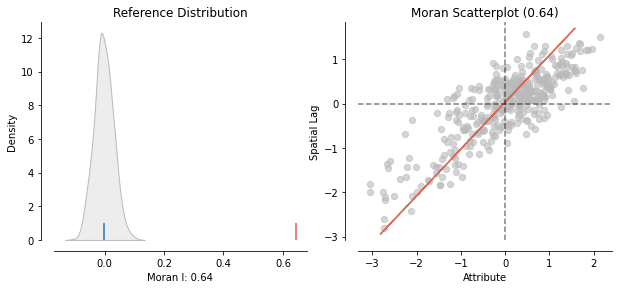

In [ ]:
from pysal.viz import splot
from splot.esda import plot_moran
plot_moran(mi);

En el panel izquierdo podemos ver en gris la distribución empírica generada al simular 999 mapas aleatorios con los valores de la variable Pct_Leave y luego calcular el Índice de Moran para cada uno de esos mapas. La línea azul señala la media. Por el contrario, la línea roja muestra el Índice de Moran calculado para la variable utilizando la geografía observada en el conjunto de datos. Es claro que el valor bajo el patrón observado es significativamente más alto que bajo la aleatoriedad. Esta percepción se confirma en el panel derecho, donde se muestra un gráfico equivalente al Gráfico de Moran que creamos anteriormente.


### Otros índices globales

#### Coeficiente de Geary (Geary's C)

La proporción de contigüidad $C$, propuesta por Geary (1954), se define como:

$$
C = \dfrac{(n-1)}
          {2 \sum_i \sum_j w_{ij}} 
    \dfrac{\sum_i \sum_j w_{ij} (y_i - y_{j})^2}
          {\sum_i (y_i - \bar{y})^2}
$$

donde $n$ es el número de observaciones, $w_{ij}$ es la celda en una matriz binaria $W$ que indica si $i$ y $j$ son vecinos ($w_{ij}=1$) o no ($w_{ij}=0$), $y_i$ es la $i$-ésima observación de la variable de interés, y $\bar{y}$ es la media muestral. Al compararlo con el índice de Moran, es evidente que ambos índices relacionan el comportamiento de $Y$ dentro del vecindario local de cada observación con el de toda la muestra. Sin embargo, también hay diferencias sutiles. Mientras que el índice de Moran realiza productos cruzados en los valores estandarizados, el coeficiente de Geary utiliza diferencias en los valores sin ninguna estandarización.

Desde el punto de vista computacional, el coeficiente de Geary es más exigente, pero se puede calcular fácilmente utilizando PySAL:


In [ ]:
geary = esda.geary.Geary(br['Pct_Leave'], w)

Which has a similar way of accessing its estimate:

In [ ]:
geary.C

0.3241572123881239

La inferencia se realiza de manera similar a como se hace con Moran. Podemos realizar una simulación que nos permita obtener una distribución empírica de la estadística bajo la hipótesis nula de aleatoriedad espacial, y luego compararla con la estadística obtenida al utilizar la distribución geográfica observada de los datos. Para acceder al valor pseudo p, calculado como en el caso de Moran, podemos llamar a `p_sim`:


In [ ]:
geary.p_sim

0.001

En este caso, Geary's C apunta en la misma dirección que Moran's I: hay una clara indicación de que la estadística que calculamos en el conjunto de datos observado es diferente de lo que se esperaría en una situación de pura aleatoriedad espacial. Por lo tanto, a partir de este análisis, también podemos concluir que existe autocorrelación espacial.


#### $G$ de Getis y Ord

Propuesto originalmente por Getis y Ord (1992), el $G$ es la versión global de una familia de estadísticas de autocorrelación espacial basadas en la distancia. La clase de estadísticas $G$ está concebida para puntos, por lo tanto, se utiliza una distancia $W$, pero también se puede aplicar a datos de malla si se puede construir una matriz binaria de pesos espaciales. Además, está diseñado para el estudio de variables positivas con un origen natural. El $G$ se puede expresar de la siguiente manera:

$$
G(d) = \dfrac{ \sum_i \sum_j w_{ij}(d) \, y_i \, y_j }
             { \sum_i \sum_j y_i \, y_j }
$$

donde $w_{ij}(d)$ es el peso binario asignado a la relación entre las observaciones $i$ y $j$ siguiendo un criterio de banda de distancia. $G$ fue originalmente propuesto como una medida de concentración en lugar de autocorrelación espacial. Como tal, es adecuado para probar en qué medida valores similares (ya sean altos o bajos) tienden a estar ubicados en el mismo lugar. En otras palabras, el $G$ es una estadística de autocorrelación espacial *positiva*. Este suele ser el interés en la mayoría de las aplicaciones de Ciencia de Datos Geográficos. Sin embargo, es importante tener en cuenta que, debido a que $G$ se puede entender como una medida de la intensidad con la que $Y$ está concentrada, la estadística no puede detectar casos de autocorrelación espacial *negativa*.

Para ilustrar su cálculo, calculemos un banda de distancia binaria $W$. Para asegurarnos de que cada observación tenga al menos un vecino, utilizaremos el método `min_threshold_distance` y proyectaremos el conjunto de datos en el CRS de Ordnance Survey (código `EPSG` 27700), expresado en metros:
 en metros:


In [ ]:
br_osgb = br.to_crs(epsg=27700)
pts = br_osgb.centroid
xys = pd.DataFrame({'X': pts.x, 'Y': pts.y})
min_thr = weights.util.min_threshold_distance(xys)
min_thr

90746.35776376339

Para que cada autoridad local tenga al menos un vecino, la banda de distancia debe ser de al menos unos 181 km. Esta información luego se puede pasar al constructor `DistanceBand`:


In [ ]:
w_db = weights.DistanceBand.from_dataframe(br_osgb, min_thr)

En este punto, estamos listos para calcular la estadística global $G$:


In [ ]:
gao = esda.getisord.G(br['Pct_Leave'], w_db)

El acceso a la estadística (`gao.G`) y atributos adicionales se puede obtener de la misma manera que con las estadísticas anteriores:


In [ ]:
print("Getis & Ord G: %.3f | Pseudo P-value: %.3f"%(gao.G, gao.p_sim))

Getis & Ord G: 0.162 | Pseudo P-value: 0.030


De manera similar, la inferencia también se puede llevar a cabo mediante simulaciones computacionales que replican varias instancias de aleatoriedad espacial utilizando los valores en la variable de interés, pero intercambiando sus ubicaciones. En este caso, el valor pseudo calculado sugiere una clara desviación de la hipótesis de no concentración.


## Autocorrelación espacial local

En el capítulo anterior exploramos el uso de medidas globales de autocorrelación espacial para plantear la pregunta de si la distribución espacial general de nuestro atributo de interés reflejaba un proceso geográficamente aleatorio o no. Estas estadísticas son útiles ya que la presencia de autocorrelación espacial tiene importantes implicaciones para el análisis estadístico posterior. Desde una perspectiva sustantiva, la autocorrelación espacial podría reflejar la operación de procesos que generan asociación entre los valores en ubicaciones cercanas. En estos casos, el modelado formal de las dimensiones espaciales de los procesos debería llevarse a cabo a continuación. Por otro lado, la autocorrelación espacial a veces puede surgir de operaciones de procesamiento de datos en las que los casos de dependencia son una forma de ruido no aleatorio en lugar de debido a procesos sustantivos. Independientemente de si la autocorrelación espacial se debe a fuentes sustantivas o de molestias, es una forma de no aleatoriedad que complica el análisis estadístico.

Por estas razones, la capacidad de determinar si la autocorrelación espacial está presente en un conjunto de datos georreferenciados es un componente crítico del conjunto de herramientas de ciencia de datos espaciales. Dicho esto, las medidas globales de autocorrelación espacial son estadísticas de "mapa completo", lo que significa que la única estadística se refiere al conjunto completo de datos. En otras palabras, las estadísticas globales de autocorrelación nos permiten detectar agrupaciones en un conjunto de datos georreferenciado. Por ejemplo, Moran's I es una buena herramienta para resumir un conjunto de datos en un único valor que informa sobre su grado de agrupamiento geográfico. Sin embargo, no es una medida adecuada para identificar áreas dentro del mapa donde se encuentran tipos específicos de valores (por ejemplo, altos, bajos). En otras palabras, Moran's I nos puede decir que los valores están agrupados en general, pero no nos informará sobre dónde están los grupos. Para ese propósito, necesitamos usar una medida local de autocorrelación espacial. Las medidas locales consideran cada observación individual y operan sobre ellas, en contraposición al conjunto de datos en su conjunto, como lo hacen las medidas globales. Debido a eso, no son buenas para resumir un mapa, pero permiten obtener más información sobre subconjuntos geográficos interesantes de los datos. En este capítulo, consideramos los Indicadores Locales de Asociación Espacial (LISAs), un contraparte local de medidas globales como Moran's I. En el núcleo de este método hay una clasificación de las observaciones en un conjunto de datos en cuatro grupos derivados del Gráfico de Moran: valores altos rodeados de valores altos (HH), valores bajos cerca de otros valores bajos (LL), valores altos entre valores bajos (HL), y viceversa (LH). Cada uno de estos grupos se llama típicamente "cuadrantes". Se puede ver una ilustración de dónde cae cada uno de estos grupos en el Gráfico de Moran a continuación:


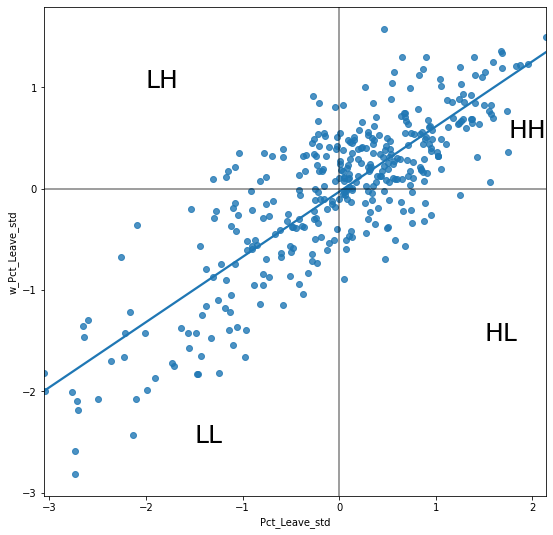

In [ ]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot values
sns.regplot(x='Pct_Leave_std', y='w_Pct_Leave_std', data=br, ci=None)
# Add vertical and horizontal lines
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
plt.text(1.75, 0.5, "HH", fontsize=25)
plt.text(1.5, -1.5, "HL", fontsize=25)
plt.text(-2, 1, "LH", fontsize=25)
plt.text(-1.5, -2.5, "LL", fontsize=25)
# Display
plt.show()

Hasta ahora hemos clasificado cada observación en el conjunto de datos según su valor y el de sus vecinos. Esto es solo la mitad del camino para identificar áreas de concentración inusual de valores. Para saber si cada una de las ubicaciones es un cluster *estadísticamente significativo* de un tipo dado, nuevamente necesitamos compararlo con lo que esperaríamos si los datos se asignaran de manera completamente aleatoria. Después de todo, por definición, cada observación será de un tipo u otro, según la comparación anterior. Sin embargo, lo que nos interesa es si la fuerza con la que los valores están concentrados es inusualmente alta.

Esto es exactamente para lo que están diseñados los LISAs. Como antes, una descripción más detallada de sus fundamentos estadísticos está fuera del alcance en este contexto, pero trataremos de arrojar algo de luz sobre la intuición de cómo lo hacen. La idea central es identificar casos en los que la comparación entre el valor de una observación y el promedio de sus vecinos sea más similar (HH, LL) o más diferente (HL, LH) de lo que esperaríamos por pura casualidad. El mecanismo para hacer esto es similar al del Moran's I global, pero aplicado en este caso a cada observación, lo que resulta en tantas estadísticas como observaciones originales.

De esta forma la gráfica de Moran queda centrada en el plot, partiendo el espacio en cuadrantes que representan:

- High-High (HH): valores por encima de la media rodeado por valores por encima de la media.
- Low-Low (LL): valores por debajo de la media rodeado por valores por debajo de la media.
- High-Low (HL): valores por encima de la media rodeado por valores por debajo de la media.
- Low-High (LH): valores por debajo de la media rodeado por valores por encima de la media.

Los LISAs se utilizan ampliamente en muchos campos para identificar clusters de valores en el espacio. Son una herramienta muy útil que puede devolver rápidamente áreas en las que los valores están concentrados y proporcionar evidencia *sugerente* sobre los procesos que podrían estar en juego. Por eso, tienen un lugar privilegiado en la caja de herramientas exploratoria. Ejemplos de contextos donde los LISAs pueden ser útiles incluyen: identificación de clusters espaciales de pobreza en regiones, detección de enclaves étnicos, delimitación de áreas de actividad particularmente alta/baja de cualquier fenómeno, etc.

En Python, podemos calcular LISAs de una manera muy simplificada gracias a `PySAL`:


In [ ]:
lisa = esda.Moran_Local(br['Pct_Leave'], w)

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

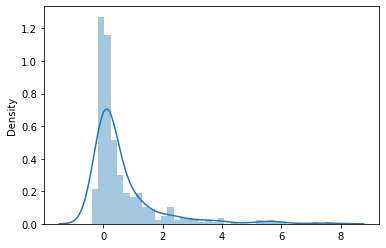

In [ ]:
sns.distplot(lisa.Is)

Esto revela una distribución bastante sesgada debido al predominio de las formas positivas de asociación espacial. Aquí es importante tener en cuenta que los valores positivos altos surgen de la similitud de valores en el espacio, y esto puede deberse a que los valores altos están al lado de valores altos o a que los valores bajos están al lado de valores bajos. Los valores locales Ii en sí mismos no pueden distinguir entre estos dos casos.

Los valores en la cola izquierda de la densidad representan ubicaciones que muestran asociación espacial negativa. También hay dos formas, un valor alto rodeado de valores bajos, o un valor bajo rodeado de observaciones vecinas de alto valor. Y, nuevamente, el valor Ii no puede distinguir entre los dos casos.

Debido a su propia naturaleza, mirar el resultado numérico de los LISAs no siempre es la forma más útil de aprovechar toda la información que pueden proporcionar. Recuerda que estamos calculando una estadística para cada observación en los datos, por lo que, si tenemos muchas de ellas, será difícil extraer algún patrón significativo. En este contexto, un mapa de coropletas puede ayudar. A primera vista, esto puede parecer sugerir que un mapa de los valores Ii sería una forma útil de visualizar la distribución espacial:


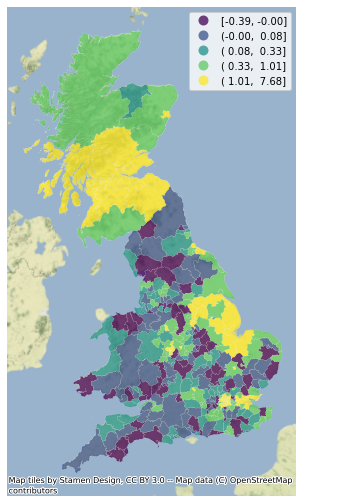

In [ ]:
f, ax = plt.subplots(1, figsize=(9,9))
br['Is'] = lisa.Is
br.plot(column='Is', cmap='viridis', scheme='quantiles',k=5, edgecolor='white', linewidth=0.1, alpha=0.75, legend=True,ax=ax);
ctx.add_basemap(ax,crs=br.crs,source=ctx.providers.Stamen.TerrainBackground)
ax.set_axis_off()

Sin embargo, esto no nos informa de ninguna manera sobre qué tipo de correlación espacial está experimentando cada área. Por ejemplo, ¿son similares las áreas amarillas en Escocia a las del clúster oriental de valores altos también? Además, sabemos que los valores alrededor de cero no serán estadísticamente significativos. ¿Cuáles son, por lo tanto, significativos y no significativos desde un punto de vista estadístico? En otras palabras, ¿cuáles pueden considerarse clústeres estadísticos y cuáles ruido? Para responder a estas preguntas, necesitamos traer información adicional que hemos obtenido al calcular las estadísticas LISA. Primero construyamos una figura de cuatro parcelas que reúna todas estas perspectivas diferentes:


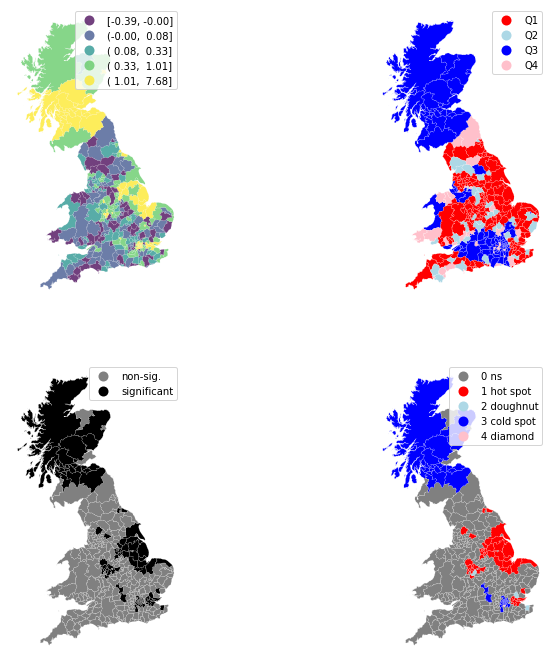

In [ ]:
from matplotlib.colors import ListedColormap
# Set up figure and axes
f, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
# Make the axes accessible with single indexing
axs = axs.flatten()

                    # Subplot 1 #
ax = axs[0]
br.plot(column='Is', cmap='viridis', scheme='quantiles',
        k=5, edgecolor='white', linewidth=0.1, alpha=0.75, legend=True, ax=ax)
ax.set_aspect('equal')
ax.set_axis_off()

                    # Subplot 2 #
ax = axs[1]
q_labels = ['Q1', 'Q2', 'Q3', 'Q4']
labels = [q_labels[i-1] for i in lisa.q]
hmap = ListedColormap([ 'red', 'lightblue', 'blue', 'pink'])
br.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)

ax.set_aspect('equal')
ax.set_axis_off()

                    # Subplot 3 #

ax = axs[2]
sig = 1 * (lisa.p_sim < 0.05)
hmap = ListedColormap(['grey','black'])
labels = ['non-sig.', 'significant'] 
labels = [labels[i] for i in sig]
br.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)

ax.set_aspect('equal')
ax.set_axis_off()
                            
                    # Subplot 4 #
ax = axs[3]
hotspot = 1 * (sig * lisa.q==1)
coldspot = 3 * (sig * lisa.q==3)
doughnut = 2 * (sig * lisa.q==2)
diamond = 4 * (sig * lisa.q==4)
spots = hotspot + coldspot + doughnut + diamond
spot_labels = [ '0 ns', '1 hot spot', '2 doughnut', '3 cold spot', '4 diamond']
labels = [spot_labels[i] for i in spots]
hmap = ListedColormap([ 'grey', 'red', 'lightblue', 'blue', 'pink'])


br.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)

ax.set_aspect('equal')
ax.set_axis_off()


# Display the figure
plt.show()

La figura en la parte superior izquierda replica nuestro primer mapa anterior. Las ubicaciones verdes y amarillas tienen los valores más grandes para las estadísticas locales, sin embargo, esto no distingue entre asociación positiva de bajo apoyo para el voto Brexit y asociación positiva de alto apoyo para el Brexit.

Para distinguir entre estos dos casos, el mapa en la parte superior derecha muestra la ubicación de la estadística LISA en el cuadrante del gráfico de dispersión de Moran, que se registra en el atributo q:


Todo lo que necesitamos pasar es la variable de interés, el porcentaje de votos para salir, y los pesos espaciales que describen las relaciones de vecindad entre las diferentes observaciones que componen el conjunto de datos.


In [ ]:
# Break observations into significant or not
br['significant'] = lisa.p_sim < 0.05
# Store the quadrant they belong to
br['quadrant'] = lisa.q

Detengámonos un momento en estos dos pasos. Primero, la columna `significant`. De manera similar al Moran's I global, `PySAL` está calculando automáticamente un valor p para cada LISA. Dado que no todas las observaciones representan una situación estadísticamente significativa, queremos identificar aquellas con un valor p lo suficientemente pequeño como para descartar la posibilidad de obtener una situación similar por pura casualidad. Siguiendo un razonamiento similar al del Moran's I global, seleccionamos el 5% como el umbral para la significancia estadística. Para identificar estos valores, creamos una variable, `significant`, que contiene `True` si el valor p de la observación satisface la condición, y `False` en caso contrario. Podemos verificar si esto es así:


In [ ]:
br['significant'].head()

LAD14CD
E06000001    False
E06000002    False
E06000003     True
E06000004     True
E06000005    False
Name: significant, dtype: bool

And the first five p-values can be checked by:

In [ ]:
lisa.p_sim[:5]

array([0.082, 0.117, 0.015, 0.02 , 0.222])

Nota cómo el tercero y el cuarto son menores que 0.05, como la variable `significant` identificó correctamente.

En segundo lugar, el cuadrante al que pertenece cada observación. Este es más fácil ya que viene incorporado directamente en el objeto `lisa`:


In [ ]:
br['quadrant'].head()

LAD14CD
E06000001    1
E06000002    1
E06000003    1
E06000004    1
E06000005    1
Name: quadrant, dtype: int64

La correspondencia entre los números en la variable y los cuadrantes reales es la siguiente:

* 1: HH
* 2: LH
* 3: LL
* 4: HL

Con estos dos elementos, `significant` y `quadrant`, podemos construir un mapa típico de clúster LISA, combinando las habilidades de mapeo con lo que hemos aprendido sobre cómo hacer subconjuntos y consultas en tablas:


We can create a quick LISA cluster map with `splot`:

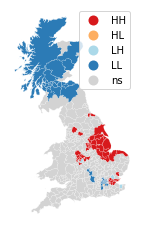

In [ ]:
from splot.esda import lisa_cluster
lisa_cluster(lisa, br);

Or, if we want to have more control over what is being displayed, and how each component is presented, we can "cook" the plot ourselves:

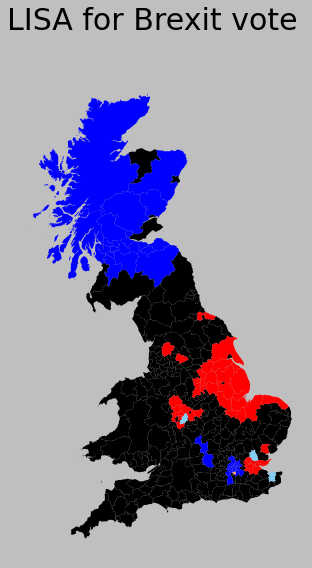

In [ ]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot insignificant clusters
ns = br.loc[br['significant']==False, 'geometry']
ns.plot(ax=ax, color='k')
# Plot HH clusters
hh = br.loc[(br['quadrant']==1) & (br['significant']==True), 'geometry']
hh.plot(ax=ax, color='red')
# Plot LL clusters
ll = br.loc[(br['quadrant']==3) & (br['significant']==True), 'geometry']
ll.plot(ax=ax, color='blue')
# Plot LH clusters
lh = br.loc[(br['quadrant']==2) & (br['significant']==True), 'geometry']
lh.plot(ax=ax, color='#83cef4')
# Plot HL clusters
hl = br.loc[(br['quadrant']==4) & (br['significant']==True), 'geometry']
hl.plot(ax=ax, color='#e59696')
# Style and draw
f.suptitle('LISA for Brexit vote', size=30)
f.set_facecolor('0.75')
ax.set_axis_off()
plt.show()

El mapa anterior muestra los resultados de LISA del voto del Brexit. En rojo brillante, encontramos aquellas autoridades locales con una concentración inusual de votantes partidarios de dejar la UE, rodeados también por niveles altos de voto a favor de dejar. Esto corresponde con áreas en el este de Inglaterra, el Black Country y el este de Londres. En rojo claro, encontramos el primer tipo de *valores atípicos espaciales*. Estas son áreas con un alto voto a favor de dejar, pero rodeadas de áreas con poco apoyo para dejar la UE (por ejemplo, el centro de Londres). Finalmente, en azul claro encontramos el otro tipo de valor atípico espacial: autoridades locales con bajo apoyo para dejar, rodeadas de otras autoridades con alto apoyo.

La interpretación sustantiva de un mapa LISA debe relacionar su resultado con la intención original del analista que creó el mapa. En este caso, nuestra idea original era explorar la estructura espacial del apoyo para salir de la UE. El LISA resulta ser una herramienta bastante útil en este contexto. Comparando el mapa LISA anterior con el coroplético con el que comenzamos, podemos interpretar el LISA como una "simplificación" de la imagen detallada pero quizás demasiado complicada en el coroplético que enfoca la atención del lector en las áreas que muestran una concentración particularmente alta de valores (dis)similares, ayudando a que la estructura espacial del voto emerja de manera más explícita. El resultado de esto destaca la relevancia que tuvieron el este de Inglaterra y las Midlands en la votación para salir, así como las regiones del mapa donde hubo mucho menos entusiasmo por salir.


The results from the LISA statistics can be connected to the Moran plot to visualise where in the scatter plot each type of polygon falls:

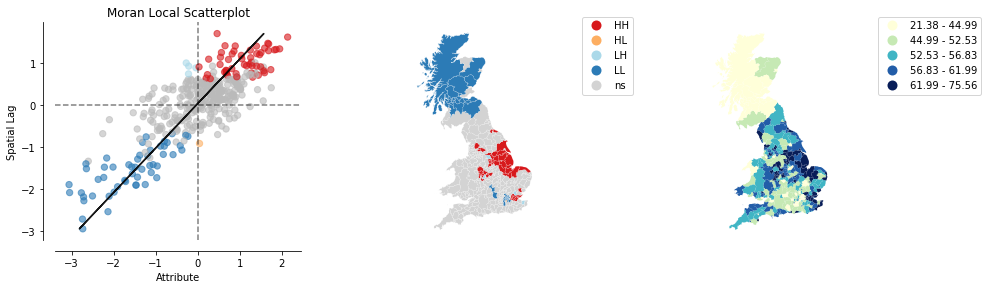

In [ ]:
from splot.esda import plot_local_autocorrelation
plot_local_autocorrelation(lisa, br, 'Pct_Leave');

## Other local indices

Similar to the global case, there are more local indicators of spatial correlation than the local Moran's I. `PySAL` includes Getis and Ord's $G_i$ and $G_i^*$, which differ only on whether to exclude the self-value in the calculation or not, respectively. The way to calculate them also follows similar patterns as with the LISA above. Let us see how that would look like for our Brexit example:

In [ ]:
# Gi
gostats = esda.getisord.G_Local(br['Pct_Leave'], w)
# Gi*
gostars = esda.getisord.G_Local(br['Pct_Leave'], w, star=True)

As the local statistics they are, it is best to explore them by plotting them on a map. Unlike with LISA though, the $G$ statistics only allow to identify positive spatial autocorrelation. When standardized, positive values imply clustering of high values, while negative implies grouping of low values. Unfortunately, it is not possible to discern spatial outliers.

In this case, let us write a little function that generates the map so we can then easily use it to generate two maps, one for $G_i$ and one for $G_i^*$:

In [ ]:
def g_map(g, geog, ax):
    '''
    Create a cluster map
    ...
    
    Arguments
    ---------
    g      : G_Local
             Object from the computation of the G statistic
    geog   : GeoDataFrame
             Table aligned with values in `g` and containing 
             the geometries to plot
    ax     : AxesSubplot
             `matplotlib` axis to draw the map on

    Returns
    -------
    ax     : AxesSubplot
             Axis with the map drawn
    '''
    ec = '0.8'
    
    # Break observations into significant or not
    sig = g.p_sim < 0.05

    # Plot non-significant clusters
    ns = br.loc[sig==False, 'geometry']
    ns.plot(ax=ax, color='grey', edgecolor=ec, linewidth=0.1)
    # Plot HH clusters
    hh = br.loc[(g.Zs > 0) & (sig==True), 'geometry']
    hh.plot(ax=ax, color='red', edgecolor=ec, linewidth=0.1)
    # Plot LL clusters
    ll = br.loc[(g.Zs < 0) & (sig==True), 'geometry']
    ll.plot(ax=ax, color='blue', edgecolor=ec, linewidth=0.1)
    # Style and draw
    ctx.add_basemap(ax, 
                           crs=br.crs, 
                           source=ctx.providers.Stamen.TerrainBackground,

                          )
    st = ''
    if g.star:
        st = '*'
    ax.set_title('G%s statistic for Pct of Leave votes'%st, size=15)
    ax.set_axis_off()
    return ax

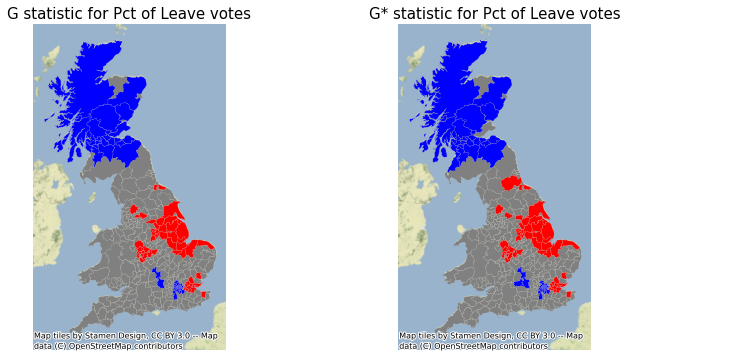

In [ ]:
# Setup figure and axes
f, axs = plt.subplots(1, 2, figsize=(12, 6))
# Loop over the two statistics and generate the map
for g, ax in zip([gostats, gostars], axs.flatten()):
    ax = g_map(g, br, ax)
# Render
plt.show()

As you can see, the results are virtually the same for $G_i$ and $G_i^*$. Also, at first glance, these maps appear to be visually similar to the final LISA map from above, and this leads to the question of why use the $G$ statistics at all. The answer to this question is that the two sets of local statistics, Local $I$ and the local $G$, are complementary statistics. This is because the local $I$ by itself cannot distinguish between the two forms of positive spatial association while the G can. At the same time, the G statistic does not consider negative spatial association, while the local I statistic does.